In [0]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
# Example taken and adapted from:
# https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944
# Data from: https://www.kaggle.com/darkknight91/ge-stock

# Parte 1: Carga y limpia los datos

In [3]:
# Requiered to select a file to be imported into colab
from google.colab import files
uploaded = files.upload()

Saving ge.us.txt to ge.us (4).txt


In [4]:
# Load file from colab (G drive)
df = pd.read_csv(io.BytesIO(uploaded['ge.us.txt']))
df.dropna(inplace=True)
df

,Date,Open,High,Low,Close,Volume,OpenInt
0,1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579,0
1,1962-01-03,0.6201,0.6201,0.6122,0.6201,1764749,0
2,1962-01-04,0.6201,0.6201,0.6037,0.6122,2194010,0
3,1962-01-05,0.6122,0.6122,0.5798,0.5957,3255244,0
4,1962-01-08,0.5957,0.5957,0.5716,0.5957,3696430,0
...,...,...,...,...,...,...,...
14053,2017-11-06,20.5200,20.5300,20.0800,20.1300,60641787,0
14054,2017-11-07,20.1700,20.2500,20.1200,20.2100,41622851,0
14055,2017-11-08,20.2100,20.3200,20.0700,20.1200,39672190,0
14056,2017-11-09,20.0400,20.0710,19.8500,19.9900,50831779,0


In [5]:
# Checking for NaN values.
print("checking if any null values are present\n", df.isna().sum())

checking if any null values are present
 Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64


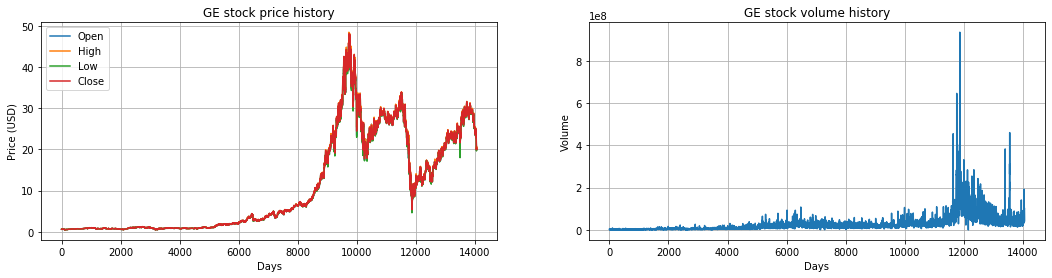

In [6]:
# Plot info
plt.figure(figsize=(18, 4))
plt.subplot(1, 2, 1)
plt.plot(df["Open"])
plt.plot(df["High"])
plt.plot(df["Low"])
plt.plot(df["Close"])
plt.title('GE stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(df["Volume"])
plt.title('GE stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.grid()
plt.show()

In [7]:
# Split train and test sets
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), "--", len(df_test))
# Still in DataFrame format

Train and Test size 11246 -- 2812


In [8]:
# Scale features and put them in matrix format (DataFrame --> Matrix)
from sklearn.preprocessing import MinMaxScaler

useful_cols = ["Open", "High", "Low", "Close", "Volume"]
X = df_train.loc[:, useful_cols].values
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X)
X_test = min_max_scaler.transform(df_test.loc[:, useful_cols])

# Here we have two sets. One with 11246 timesteps, each of 5 features, and other
# with 2812 timesteps, each of 5 features
print(X_train.shape)
print(X_test.shape)

(11246, 5)
(2812, 5)


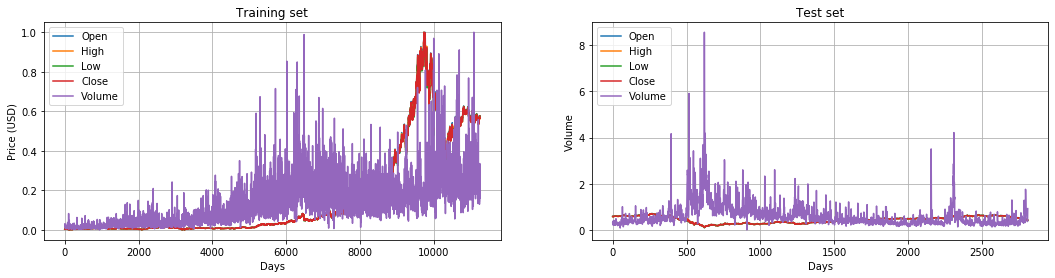

In [9]:
# Plot info
plt.figure(figsize=(18, 4))
plt.subplot(1, 2, 1)
plt.plot(X_train)
plt.title('Training set')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close', 'Volume'], loc='upper left')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(X_test)
plt.title('Test set')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close', 'Volume'], loc='upper left')
plt.grid()
plt.show()

# Parte 2: Formatea los datos para procesarlos con RNNs

In [0]:
# GOAL:
# Predict 'close' value, from 4 historic timesteps,
# close[t] = f(x[t-1] ,x[t-2], x[t-3], x[t-4]; \Omega),
# where x[t] = [open, high, low, close, volume][t]

In [0]:
# AUX funtion to build time-series dataset
def build_dataset(X, Y, hist_size):
  '''
  Params
    X: data matrix [n_time_steps, n_X_feats]
    Y: label matrix [n_time_steps, n_Y_feats]
    hist_size: integer indicating the number of time steps in each sample of x
  Returns
    x: tensor of input data [n_samples, n_timesteps, n_X_features]
    y: tensor of output data [n_samples, n_Y_features]
  '''
  n_samples = Y.shape[0] - hist_size
  x = np.zeros((n_samples, hist_size, X.shape[1]))
  y = np.zeros((n_samples))

  for ind in range(n_samples):    
    x[ind] = X[ind : ind + hist_size]
    y[ind] = Y[ind + hist_size]
  return x, y

In [12]:
time_steps = 4
n_samples = X_train[:, 3].shape[0] - time_steps
n_samples

11242

In [13]:
x = np.zeros((n_samples, time_steps, X_train.shape[1]))
x

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]])

In [14]:
y = np.zeros((n_samples))
y

array([0., 0., 0., ..., 0., 0., 0.])

In [0]:
for ind in range(n_samples):    
    x[ind] = X_train[ind : ind + time_steps]
    y[ind] = X_train[:, 3][ind + time_steps]

In [16]:
x

array([[[0.00356678, 0.00352766, 0.00358385, 0.00338425, 0.02108267],
        [0.00340607, 0.00319219, 0.00341628, 0.00338425, 0.01365459],
        [0.00340607, 0.00319219, 0.00323598, 0.00321827, 0.01758709],
        [0.00323903, 0.00302758, 0.00272904, 0.00287161, 0.02730914]],

       [[0.00340607, 0.00319219, 0.00341628, 0.00338425, 0.01365459],
        [0.00340607, 0.00319219, 0.00323598, 0.00321827, 0.01758709],
        [0.00323903, 0.00302758, 0.00272904, 0.00287161, 0.02730914],
        [0.00289013, 0.00268378, 0.0025551 , 0.00287161, 0.03135089]],

       [[0.00340607, 0.00319219, 0.00323598, 0.00321827, 0.01758709],
        [0.00323903, 0.00302758, 0.00272904, 0.00287161, 0.02730914],
        [0.00289013, 0.00268378, 0.0025551 , 0.00287161, 0.03135089],
        [0.00289013, 0.00285047, 0.00289873, 0.00287161, 0.02293968]],

       ...,

       [[0.57216847, 0.5651576 , 0.57140609, 0.56782972, 0.22143607],
        [0.57047685, 0.56280304, 0.56966677, 0.5649724 , 0.20303429],
 

In [17]:
X_train[0 : 4]

array([[0.00356678, 0.00352766, 0.00358385, 0.00338425, 0.02108267],
       [0.00340607, 0.00319219, 0.00341628, 0.00338425, 0.01365459],
       [0.00340607, 0.00319219, 0.00323598, 0.00321827, 0.01758709],
       [0.00323903, 0.00302758, 0.00272904, 0.00287161, 0.02730914]])

In [18]:
X_train

array([[0.00356678, 0.00352766, 0.00358385, 0.00338425, 0.02108267],
       [0.00340607, 0.00319219, 0.00341628, 0.00338425, 0.01365459],
       [0.00340607, 0.00319219, 0.00323598, 0.00321827, 0.01758709],
       ...,
       [0.56738965, 0.56144866, 0.56900922, 0.56564471, 0.16041384],
       [0.56658613, 0.5678247 , 0.56695173, 0.57270398, 0.24217621],
       [0.57639752, 0.57292971, 0.57755734, 0.57677987, 0.25339457]])

In [19]:
y

array([0.00287161, 0.00287161, 0.00287161, ..., 0.56564471, 0.57270398,
       0.57677987])

In [20]:
X_train[0:5, 3]

array([0.00338425, 0.00338425, 0.00321827, 0.00287161, 0.00287161])

In [0]:
# AUX funtion to build time-series dataset
# def build_dataset(data, y_ind, steps_ahed):
    # y_ind is the index of the column that would act as output y
    # the total number of time-series samples would be len(data) - steps_ahed
    # n_samples = data.shape[0] - steps_ahed
    # n_features = data.shape[1]
    # x = np.zeros((n_samples, steps_ahed, n_features))
    # y = np.zeros((n_samples,))
    
    # for ind in range(n_samples):
        # x[ind] = data[ind : steps_ahed + ind]
        # y[ind] = data[steps_ahed + ind, y_ind]
    # return x, y

In [22]:
# Create time-series datasets: Use all features as input, and 'close' as output.
time_steps = 4
x_train, y_train = build_dataset(X_train, X_train[:, 3], time_steps)
x_test,  y_test  = build_dataset(X_test,  X_test[:, 3],  time_steps)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(11242, 4, 5)
(2808, 4, 5)
(11242,)
(2808,)


In [23]:
# Print some examples
print("Original first elements")
print(X_train[:10])
print("\nTime-series format of first elements x")
print(x_train[:4])
print("\nTime-series format of first elements y")
print(y_train[:4])

Original first elements
[[0.00356678 0.00352766 0.00358385 0.00338425 0.02108267]
 [0.00340607 0.00319219 0.00341628 0.00338425 0.01365459]
 [0.00340607 0.00319219 0.00323598 0.00321827 0.01758709]
 [0.00323903 0.00302758 0.00272904 0.00287161 0.02730914]
 [0.00289013 0.00268378 0.0025551  0.00287161 0.03135089]
 [0.00289013 0.00285047 0.00289873 0.00287161 0.02293968]
 [0.00289013 0.00285047 0.00306629 0.00287161 0.01889791]
 [0.00289013 0.00268378 0.00289873 0.00287161 0.01529311]
 [0.00289013 0.00285047 0.00289873 0.00270563 0.01594855]
 [0.00289013 0.00268378 0.00306629 0.00287161 0.02064569]]

Time-series format of first elements x
[[[0.00356678 0.00352766 0.00358385 0.00338425 0.02108267]
  [0.00340607 0.00319219 0.00341628 0.00338425 0.01365459]
  [0.00340607 0.00319219 0.00323598 0.00321827 0.01758709]
  [0.00323903 0.00302758 0.00272904 0.00287161 0.02730914]]

 [[0.00340607 0.00319219 0.00341628 0.00338425 0.01365459]
  [0.00340607 0.00319219 0.00323598 0.00321827 0.01758709]

# Parte 3: Crea la RNN y entrenala

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, SimpleRNN, Dense

In [25]:
rnn_model = Sequential()
rnn_model.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
rnn_model.add(SimpleRNN(units=32))
rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                1216      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile
rnn_model.compile(loss='mean_squared_error', optimizer='rmsprop')

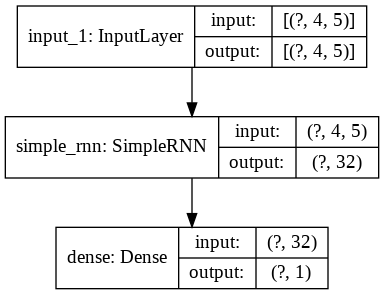

In [27]:
# Plot model
from tensorflow.keras.utils import plot_model
plot_model(rnn_model, show_shapes=True, show_layer_names=True,
                          rankdir='TB', expand_nested=True, dpi=96)

In [28]:
# Weights in the first layer (simpleRNN, Input does not count as layer)
W_xh, W_hh, W_yh = rnn_model.layers[0].get_weights()
print(W_xh.shape)
print(W_hh.shape)
print(W_yh.shape)

# == Q1 == 
# Renombra los ndarrays A, B, C, usando la notación vista en clase: W(h), W(x), etc...

(5, 32)
(32, 32)
(32,)


In [29]:
# Weights in the second layer (FullyConnected)
W, b = rnn_model.layers[1].get_weights()
print(W.shape)
print(b.shape)

(32, 1)
(1,)


In [30]:
# Train
history = rnn_model.fit(x_train, y_train, epochs=32, verbose=1, batch_size=4, validation_split=0.1)

Train on 10117 samples, validate on 1125 samples
Epoch 1/32
10117/10117 [==============================] - 5s 480us/sample - loss: 0.0023 - val_loss: 3.1960e-04
Epoch 2/32
10117/10117 [==============================] - 5s 458us/sample - loss: 2.2215e-04 - val_loss: 1.2220e-04
Epoch 3/32
10117/10117 [==============================] - 5s 451us/sample - loss: 1.5857e-04 - val_loss: 0.0029
Epoch 4/32
10117/10117 [==============================] - 5s 448us/sample - loss: 1.3671e-04 - val_loss: 1.3877e-04
Epoch 5/32
10117/10117 [==============================] - 5s 447us/sample - loss: 1.2275e-04 - val_loss: 1.8472e-04
Epoch 6/32
10117/10117 [==============================] - 5s 448us/sample - loss: 1.1102e-04 - val_loss: 5.6296e-04
Epoch 7/32
10117/10117 [==============================] - 5s 448us/sample - loss: 1.0110e-04 - val_loss: 1.6996e-04
Epoch 8/32
10117/10117 [==============================] - 5s 447us/sample - loss: 9.4525e-05 - val_loss: 4.9441e-04
Epoch 9/32
10117/10117 [=======

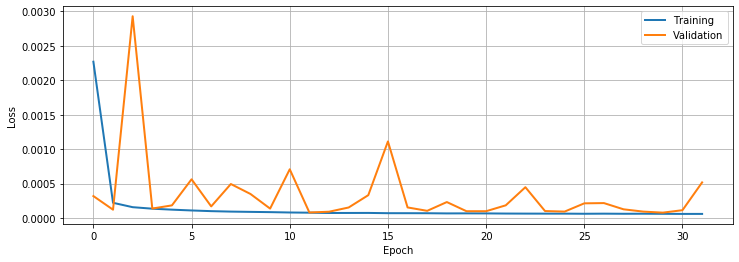

In [31]:
# Plot loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [32]:
# Predict on training and test sets
y_train_hat = rnn_model.predict(x_train)
y_test_hat = rnn_model.predict(x_test)
print(y_train_hat.shape)
print(y_test_hat.shape)

(11242, 1)
(2808, 1)


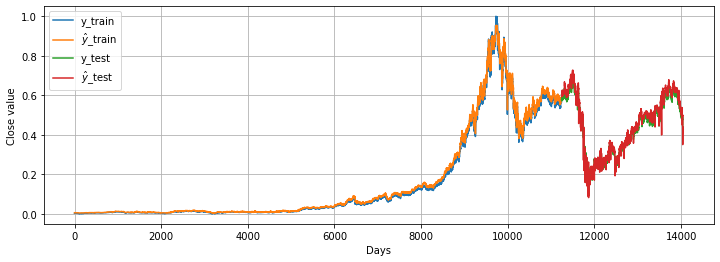

In [33]:
# Plot y_train, y_train_hat, y_test and y_test_hat
x_ticks = np.arange(len(y_train) + len(y_test)) # Para poder imprimir test delante de train

plt.figure(figsize=(12, 4))
plt.plot(x_ticks[:len(y_train)], y_train)
plt.plot(x_ticks[:len(y_train)], y_train_hat)
plt.plot(x_ticks[len(y_train):], y_test)
plt.plot(x_ticks[len(y_train):], y_test_hat)
plt.ylabel('Close value')
plt.xlabel('Days')
plt.legend(['y_train', '$\hat{y}$_train', 'y_test', '$\hat{y}$_test'], loc='upper left')
plt.grid()
plt.show()

In [0]:
# == Q2 ==
# El rendimiento es excelente, sin embargo, hay un problema de dependencia en los datos.
# ¿Puedes notar cuál es, y explicar el excelente rendimiento?
# Si, el excelente rendimiento se debe a que estamos incluyendo la variable que buscamos predecir ('close' -- X_train[:, 3]) en 
# las variables explicativas. Esto se conoce como data leaking, es decir, estamos utilizando información que en un escenario real 
# no tendríamos.


# Parte 4: Predice con "delay"

In [0]:
# == Q3 ==
# Crea una función "delayed_dataset" que formatee los datos para asociar y[t] con
# x[t-delay] hasta x[t-delay-history]. Por ejemplo, para hacer prónosticos del tipo
# y[10] = f(x[7], x[6], x[5]; \Omega). Donde tanto x como y pueden ser univariados o multivariados.
#
# For instance, calling such a function with the 
# x_train, y_train = delayed_dataset(X_train[:20, :3], X_train[:20, 3:], delay=2, hist=4)
# must return x_train and y_train with the following shapes,
# x_train.shape = (14, 4, 3) # 14 samples, each of 4 time-steps, each of 3 features
# y_train.shape = (14, 2)    # 14 label-samples, each of two values
#
# The following table shows indices information (not need to print it)
# IND:  0, Xids:  0 --  3, -- Yids:  5
# IND:  1, Xids:  1 --  4, -- Yids:  6
# IND:  2, Xids:  2 --  5, -- Yids:  7
# IND:  3, Xids:  3 --  6, -- Yids:  8
# IND:  4, Xids:  4 --  7, -- Yids:  9
# IND:  5, Xids:  5 --  8, -- Yids: 10
# IND:  6, Xids:  6 --  9, -- Yids: 11
# IND:  7, Xids:  7 -- 10, -- Yids: 12
# IND:  8, Xids:  8 -- 11, -- Yids: 13
# IND:  9, Xids:  9 -- 12, -- Yids: 14
# IND: 10, Xids: 10 -- 13, -- Yids: 15
# IND: 11, Xids: 11 -- 14, -- Yids: 16
# IND: 12, Xids: 12 -- 15, -- Yids: 17
# IND: 13, Xids: 13 -- 16, -- Yids: 18

Entendiendo que hace la función build_dataset linea a linea

In [0]:
# GOAL:
# Predict 'close' value, from 4 historic timesteps,
# close[t] = f(x[t-1] ,x[t-2], x[t-3], x[t-4]; \Omega),
# where x[t] = [open, high, low, close, volume][t]

In [0]:
# AUX funtion to build time-series dataset
def build_dataset(X, Y, hist_size):
  '''
  Params
    X: data matrix [n_time_steps, n_X_feats]
    Y: label matrix [n_time_steps, n_Y_feats]
    hist_size: integer indicating the number of time steps in each sample of x
  Returns
    x: tensor of input data [n_samples, n_timesteps, n_X_features]
    y: tensor of output data [n_samples, n_Y_features]
  '''
  n_samples = Y.shape[0] - hist_size
  x = np.zeros((n_samples, hist_size, X.shape[1]))
  y = np.zeros((n_samples))

  for ind in range(n_samples):    
    x[ind] = X[ind : ind + hist_size]
    y[ind] = Y[ind + hist_size]
  return x, y

In [37]:
X_train

array([[0.00356678, 0.00352766, 0.00358385, 0.00338425, 0.02108267],
       [0.00340607, 0.00319219, 0.00341628, 0.00338425, 0.01365459],
       [0.00340607, 0.00319219, 0.00323598, 0.00321827, 0.01758709],
       ...,
       [0.56738965, 0.56144866, 0.56900922, 0.56564471, 0.16041384],
       [0.56658613, 0.5678247 , 0.56695173, 0.57270398, 0.24217621],
       [0.57639752, 0.57292971, 0.57755734, 0.57677987, 0.25339457]])

In [38]:
X_train[:,3]

array([0.00338425, 0.00338425, 0.00321827, ..., 0.56564471, 0.57270398,
       0.57677987])

In [39]:
X_train[:,3].shape[0]

11246

In [40]:
X_train[:,3].shape[0] - time_steps

11242

In [41]:
X_train.shape[1]

5

In [0]:
# AUX funtion to build time-series dataset
def delayed_dataset(X, Y, delay, hist_size):
  '''
  Params
    X: data matrix [n_time_steps, n_X_feats]
    Y: label matrix [n_time_steps, n_Y_feats]
    delay: integer indicating the delay between last time step in x and time step in y
    hist_size: integer indicating the number of time steps in each sample of x
  Returns
    x: tensor of input data [n_samples, n_timesteps, n_X_features]
    y: tensor of output data [n_samples, n_Y_features]
  '''
  n_samples = Y.shape[0] - hist_size - delay
  x = np.zeros((n_samples, hist_size, X.shape[1]))
  y = np.zeros((n_samples, Y.shape[1]))

  for ind in range(n_samples):    
    x[ind] = X[ind : ind + hist_size]
    y[ind] = Y[ind + hist_size + delay]
  return x, y

In [43]:
hist_size = 4
delay = 3
n_samples = X_train[:, 3:].shape[0] - hist_size - delay
n_samples

11239

In [44]:
x = np.zeros((n_samples, hist_size, X_train[:, :3].shape[1]))
x

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [45]:
y = np.zeros((n_samples))
y

array([0., 0., 0., ..., 0., 0., 0.])

In [46]:
x.shape[2]

3

In [47]:
# Usa la función anterior para generar sets de entrenamiento y validación donde,
# x contenga (open, high, low), e y contenga (close, volume)
# Considera delay=3 y history_size=4
x_train, y_train = delayed_dataset(X_train[:, :3], X_train[:, 3:], 3, 4)
x_test, y_test = delayed_dataset(X_test[:, :3], X_test[:, 3:], 3, 4)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(11239, 4, 3)
(2805, 4, 3)
(11239, 2)
(2805, 2)


In [0]:
# == Q4 ==
# Diseña una RNN para resolver el problema de regresion multivariada que acabas de generar.
# Reporta el mejor resultado que hayas obtenido.

In [49]:
# Your RNN Here
rnn_model = Sequential()

rnn_model.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
rnn_model.add(SimpleRNN(units=32))
rnn_model.add(Dense(2, activation='sigmoid'))

rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 32)                1152      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 1,218
Trainable params: 1,218
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile
rnn_model.compile(loss='mean_squared_error', optimizer='rmsprop')

In [51]:
# Train
history = rnn_model.fit(x_train, y_train, epochs=32, verbose=1, batch_size=4, validation_split=0.1)

Train on 10115 samples, validate on 1124 samples
Epoch 1/32
10115/10115 [==============================] - 5s 490us/sample - loss: 0.0048 - val_loss: 0.0097
Epoch 2/32
10115/10115 [==============================] - 5s 477us/sample - loss: 0.0024 - val_loss: 0.0079
Epoch 3/32
10115/10115 [==============================] - 5s 486us/sample - loss: 0.0024 - val_loss: 0.0098
Epoch 4/32
10115/10115 [==============================] - 5s 461us/sample - loss: 0.0023 - val_loss: 0.0094
Epoch 5/32
10115/10115 [==============================] - 5s 462us/sample - loss: 0.0023 - val_loss: 0.0084
Epoch 6/32
10115/10115 [==============================] - 5s 465us/sample - loss: 0.0023 - val_loss: 0.0087
Epoch 7/32
10115/10115 [==============================] - 5s 462us/sample - loss: 0.0023 - val_loss: 0.0094
Epoch 8/32
10115/10115 [==============================] - 5s 455us/sample - loss: 0.0023 - val_loss: 0.0120
Epoch 9/32
10115/10115 [==============================] - 5s 463us/sample - loss: 0.002

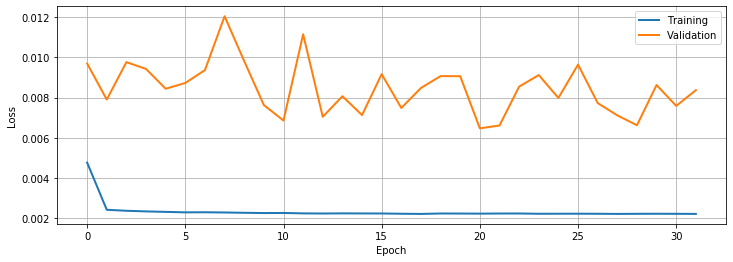

In [52]:
# Plot loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [53]:
# Predict on training and test sets
y_train_hat = rnn_model.predict(x_train)
y_test_hat = rnn_model.predict(x_test)
print(y_train_hat.shape)
print(y_test_hat.shape)

(11239, 2)
(2805, 2)


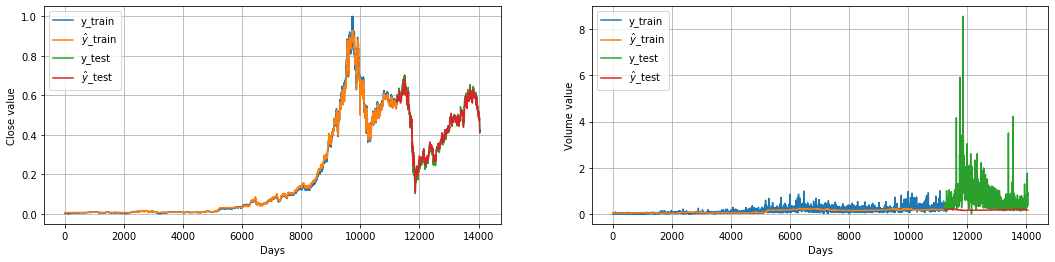

In [54]:
# Plot y_train, y_train_hat, y_test and y_test_hat
x_ticks = np.arange(len(y_train) + len(y_test))

plt.figure(figsize=(18, 4))
plt.subplot(1, 2, 1)
plt.plot(x_ticks[:len(y_train)], y_train[:, 0])
plt.plot(x_ticks[:len(y_train)], y_train_hat[:, 0])
plt.plot(x_ticks[len(y_train):], y_test[:, 0])
plt.plot(x_ticks[len(y_train):], y_test_hat[:, 0])
plt.ylabel('Close value')
plt.xlabel('Days')
plt.legend(['y_train', '$\hat{y}$_train', 'y_test', '$\hat{y}$_test'], loc='upper left')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x_ticks[:len(y_train)], y_train[:, 1])
plt.plot(x_ticks[:len(y_train)], y_train_hat[:, 1])
plt.plot(x_ticks[len(y_train):], y_test[:, 1])
plt.plot(x_ticks[len(y_train):], y_test_hat[:, 1])
plt.ylabel('Volume value')
plt.xlabel('Days')
plt.legend(['y_train', '$\hat{y}$_train', 'y_test', '$\hat{y}$_test'], loc='upper left')
plt.grid()

plt.show()

In [0]:
# == Q5 ==
# Parece que predecir 'close' es muy fácil, pero no predecir 'volume'.
# Explica las razones por las cuales crees que obtienes esos resultados.
# Se puede observar en la grafica de "Volume" que el rango de valores del volumen de y_test (Despues de 11,000 dias [Aprox]) son atípicos 
# comparado contra el rango de los valores de y_train que son con los que se entreno la red. Gracias a ésto el y_gorro_test
# mantiene el mismo piso que los valores bajo los que fue entrenado trayendo como consecuencia un gap importante entre el y_gorro_test
# y el y_test.

In [56]:
# == Q6 ==
# Ahora encuentra la forma de pasar columnas no consecutivas a la función "delayed_dataset".
# Crea sets donde,
# x contenga (open, low, volume), e y contenga (high, close)
# Considera delay=3 y history_size=4
x_train, y_train = delayed_dataset(X_train[:, (1,1,1)], X_train[:, (1,3)],
                                   delay=3, hist_size=4)
x_test, y_test   = delayed_dataset(X_test[:, (1,1,1)], X_test[:, (1,3)], 
                                 delay=3, hist_size=4)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(11239, 4, 3)
(2805, 4, 3)
(11239, 2)
(2805, 2)


In [0]:
# == Q7 ==
# Diseña una red para resolver este último problema de regresión.
# Reporta tu red con el mejor resultado.

In [58]:
# Your RNN Here
rnn_model = Sequential()

rnn_model.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
rnn_model.add(SimpleRNN(units=32))
rnn_model.add(Dense(32, activation='relu'))
rnn_model.add(Dense(2, activation='sigmoid'))

rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 32)                1152      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 2,274
Trainable params: 2,274
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile
rnn_model.compile(loss='mean_squared_error', optimizer='rmsprop')

In [60]:
# Train
history = rnn_model.fit(x_train, y_train, epochs=32, verbose=1, batch_size=4, validation_split=0.1)

Train on 10115 samples, validate on 1124 samples
Epoch 1/32
10115/10115 [==============================] - 5s 529us/sample - loss: 0.0022 - val_loss: 2.9617e-04
Epoch 2/32
10115/10115 [==============================] - 5s 482us/sample - loss: 2.5455e-04 - val_loss: 3.0386e-04
Epoch 3/32
10115/10115 [==============================] - 5s 490us/sample - loss: 2.1535e-04 - val_loss: 2.6369e-04
Epoch 4/32
10115/10115 [==============================] - 5s 485us/sample - loss: 2.0636e-04 - val_loss: 0.0063
Epoch 5/32
10115/10115 [==============================] - 5s 484us/sample - loss: 1.8835e-04 - val_loss: 5.3172e-04
Epoch 6/32
10115/10115 [==============================] - 5s 483us/sample - loss: 1.7771e-04 - val_loss: 5.5719e-04
Epoch 7/32
10115/10115 [==============================] - 5s 486us/sample - loss: 1.7581e-04 - val_loss: 8.1383e-04
Epoch 8/32
10115/10115 [==============================] - 5s 485us/sample - loss: 1.6281e-04 - val_loss: 4.9936e-04
Epoch 9/32
10115/10115 [=======

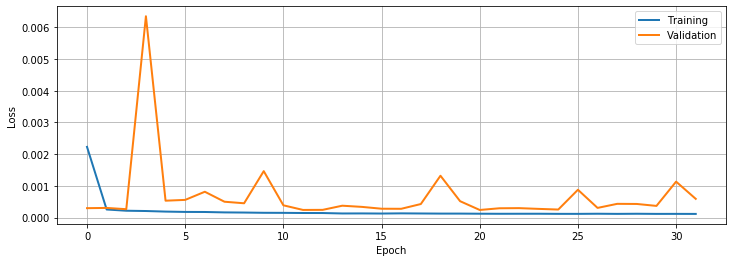

In [61]:
# Plot loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [62]:
# Predict on training and test sets
y_train_hat = rnn_model.predict(x_train)
y_test_hat = rnn_model.predict(x_test)
print(y_train_hat.shape)
print(y_test_hat.shape)

(11239, 2)
(2805, 2)


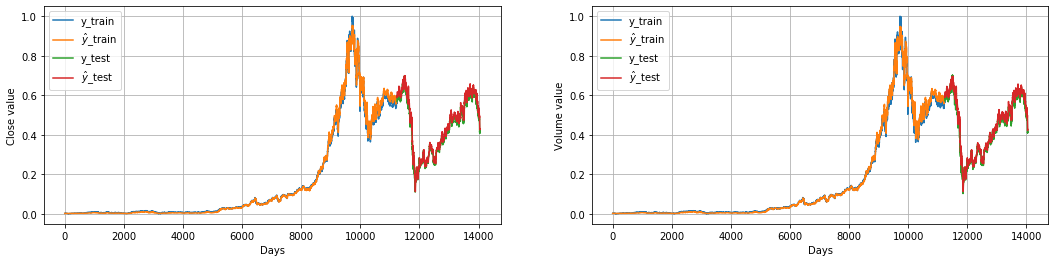

In [64]:
# Plot y_train, y_train_hat, y_test and y_test_hat
x_ticks = np.arange(len(y_train) + len(y_test))

plt.figure(figsize=(18, 4))
plt.subplot(1, 2, 1)
plt.plot(x_ticks[:len(y_train)], y_train[:, 0])
plt.plot(x_ticks[:len(y_train)], y_train_hat[:, 0])
plt.plot(x_ticks[len(y_train):], y_test[:, 0])
plt.plot(x_ticks[len(y_train):], y_test_hat[:, 0])
plt.ylabel('Close value')
plt.xlabel('Days')
plt.legend(['y_train', '$\hat{y}$_train', 'y_test', '$\hat{y}$_test'], loc='upper left')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x_ticks[:len(y_train)], y_train[:, 1])
plt.plot(x_ticks[:len(y_train)], y_train_hat[:, 1])
plt.plot(x_ticks[len(y_train):], y_test[:, 1])
plt.plot(x_ticks[len(y_train):], y_test_hat[:, 1])
plt.ylabel('Volume value')
plt.xlabel('Days')
plt.legend(['y_train', '$\hat{y}$_train', 'y_test', '$\hat{y}$_test'], loc='upper left')
plt.grid()

plt.show()
# NOTA: las gráficas son muy parecidas, pero no iguales. -- El desempeño es bueno.